<a href="https://colab.research.google.com/github/evaagustine/PilahinAi/blob/main/Transfer_Learning_Model_Updated_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from os import getcwd
import matplotlib.pyplot as plt

#Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
BASE_DIR = os.path.join('/content','gdrive','Shareddrives','Buangin Applications', 'Waste Image Dataset Update')


In [4]:
!ls gdrive/Shareddrives/Buangin\ Applications/Waste\ Image\ Dataset\ Update

test  train


#EDA

In [5]:
print(len(os.listdir(BASE_DIR + '/train/')))
print(len(os.listdir(BASE_DIR + '/test/')))

3
3


In [6]:
TRAINING_ANORGANIK_DIR = BASE_DIR + "/train/Anorganik/"
TESTING_ANORGANIK_DIR = BASE_DIR + "/test/Anorganik/"
TRAINING_ORGANIK_DIR = BASE_DIR + "/train/Organik/"
TESTING_ORGANIK_DIR = BASE_DIR + "/test/Organik/"
TRAINING_BERACUN_DIR = BASE_DIR + "/train/Beracun/"
TESTING_BERACUN_DIR = BASE_DIR + "/test/Beracun/"

In [7]:
print(len(os.listdir(TRAINING_ANORGANIK_DIR)))
print(len(os.listdir(TESTING_ANORGANIK_DIR)))
print(len(os.listdir(TRAINING_ORGANIK_DIR)))
print(len(os.listdir(TESTING_ORGANIK_DIR)))
print(len(os.listdir(TRAINING_BERACUN_DIR)))
print(len(os.listdir(TESTING_BERACUN_DIR)))

1567
347
1502
300
1500
300


In [8]:
TRAINING_DIR = BASE_DIR + "/train"
VALIDATION_DIR = BASE_DIR + "/test"

##Augmentation

In [9]:
IMG_SHAPE = 300,300
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=IMG_SHAPE,
    batch_size=10,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SHAPE,
    batch_size=10,
    class_mode='categorical')

Found 4569 images belonging to 3 classes.
Found 947 images belonging to 3 classes.


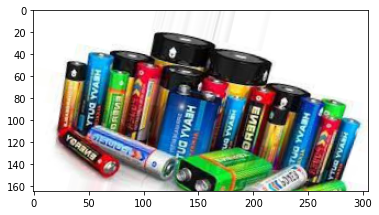

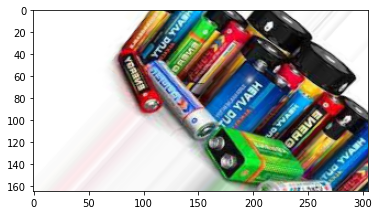

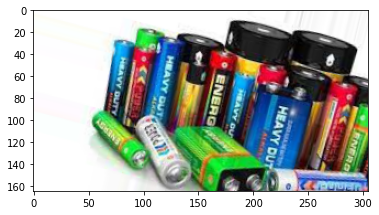

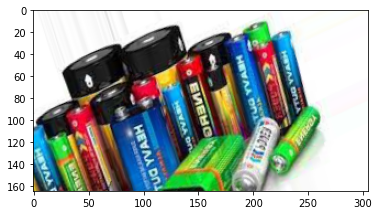

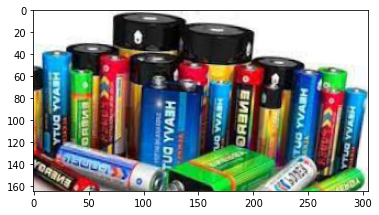

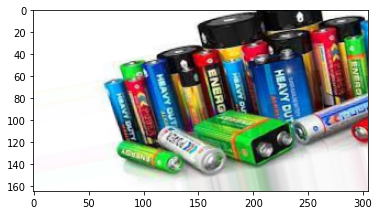

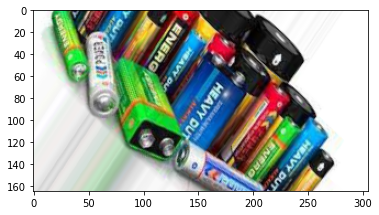

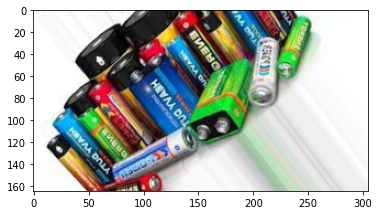

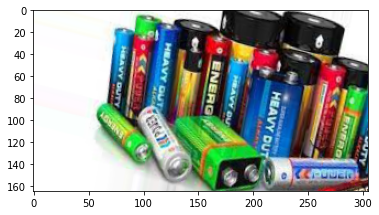

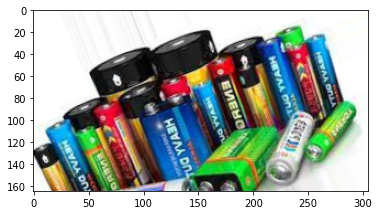

In [10]:
img = load_img(BASE_DIR + '/train/Beracun/battery3.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 10 == 0:
    break

#Modelling

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions

In [12]:
#Modelling with Inception

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  # Your Code Here
  layer.trainable = False

pre_trained_model.summary()


87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [13]:
last_layer = pre_trained_model.get_layer('mixed9_0')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 768)


In [14]:
#Create a callbacks

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [15]:
#Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(3, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
457/457 [==============================] - 2012s 4s/step - loss: 0.5027 - accuracy: 0.8779 - val_loss: 0.2208 - val_accuracy: 0.9398
Epoch 2/10
457/457 [==============================] - 137s 300ms/step - loss: 0.2200 - accuracy: 0.9302 - val_loss: 0.2149 - val_accuracy: 0.9314
Epoch 3/10
457/457 [==============================] - 136s 297ms/step - loss: 0.1690 - accuracy: 0.9453 - val_loss: 0.2229 - val_accuracy: 0.9261
Epoch 4/10
457/457 [==============================] - 135s 296ms/step - loss: 0.1430 - accuracy: 0.9573 - val_loss: 0.2248 - val_accuracy: 0.9440
Epoch 5/10
457/457 [==============================] - 135s 296ms/step - loss: 0.1398 - accuracy: 0.9564 - val_loss: 0.1900 - val_accuracy: 0.9409
Epoch 6/10
457/457 [==============================] - 135s 296ms/step - loss: 0.1475 - accuracy: 0.9558 - val_loss: 0.2101 - val_accuracy: 0.9398
Epoch 7/10
457/457 [==============================] - 135s 295ms/step - loss: 0.1104 - accuracy: 0.9667 - val_loss: 0.1436 - v

#Evaluation

Text(0.5, 1.0, 'Training and validation loss')

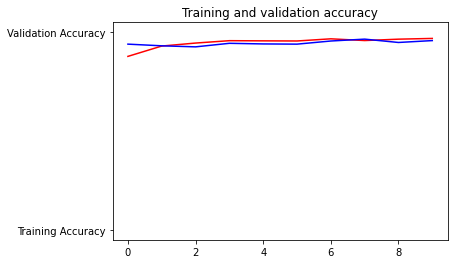

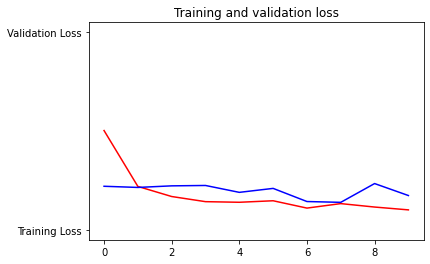

In [17]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


#Test

In [18]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 300, 300, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Anorganic', 'Toxic Waste', 'Organic']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Anorganic'
  elif predict_label == 1:
      predict_product = 'Toxic Waste'
  else:
      predict_product = 'Organic'

  return predict_product, df

Saving download.jpg to download (4).jpg




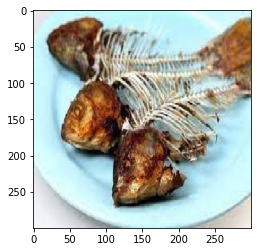


The image is detected as Organic


       Product  Probability
0    Anorganic     0.000008
1  Toxic Waste     0.000048
2      Organic     0.999944




In [28]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(300,300))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')

#Iteration

## Trying more epochs

In [ ]:
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
457/457 [==============================] - 219s 478ms/step - loss: 0.1166 - accuracy: 0.9621 - val_loss: 0.1313 - val_accuracy: 0.9630
Epoch 2/30
457/457 [==============================] - 218s 476ms/step - loss: 0.1187 - accuracy: 0.9665 - val_loss: 0.1017 - val_accuracy: 0.9757
Epoch 3/30
457/457 [==============================] - 221s 484ms/step - loss: 0.1164 - accuracy: 0.9680 - val_loss: 0.1549 - val_accuracy: 0.9715
Epoch 4/30
457/457 [==============================] - 219s 479ms/step - loss: 0.1214 - accuracy: 0.9672 - val_loss: 0.1990 - val_accuracy: 0.9588
Epoch 5/30
457/457 [==============================] - 219s 478ms/step - loss: 0.1130 - accuracy: 0.9680 - val_loss: 0.1760 - val_accuracy: 0.9599
Epoch 6/30
457/457 [==============================] - 220s 480ms/step - loss: 0.1195 - accuracy: 0.9715 - val_loss: 0.1219 - val_accuracy: 0.9694
Epoch 7/30
457/457 [==============================] - 219s 479ms/step - loss: 0.0761 - accuracy: 0.9753 - val_loss: 0.1590 -

Text(0.5, 1.0, 'Training and validation loss')

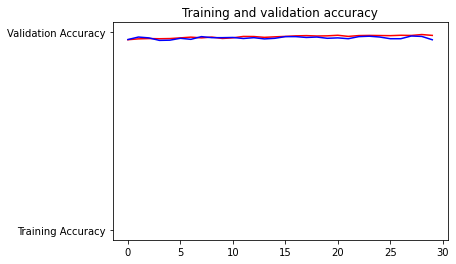

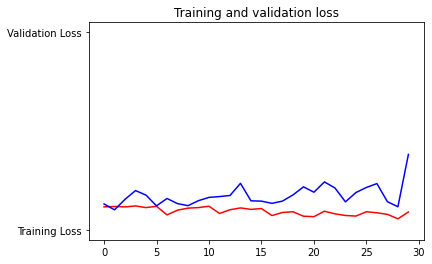

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


It is overfit because it is too many epochs

##Mobile Net

In [29]:
import tensorflow
print(tensorflow.__version__)

2.5.0


In [30]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

In [31]:
#Mobile Net for feature extractions
pretrained_mobile_net = tf.keras.applications.MobileNetV2(input_shape=(300,300,3),
                                                          include_top = False,
                                                          weights='imagenet')

for layer in pretrained_mobile_net.layers:
  layer.trainable = False

pretrained_mobile_net.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
________________

In [32]:
x = pretrained_mobile_net.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(3, activation='softmax')(x)           

model_mobilenet = Model(pretrained_mobile_net.input, x) 

model_mobilenet.compile(optimizer = Adam(lr=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_mobilenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [33]:
callbacks = myCallback()
history = model_mobilenet.fit_generator(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
457/457 [==============================] - 137s 294ms/step - loss: 5.6301 - accuracy: 0.8321 - val_loss: 0.3200 - val_accuracy: 0.8997
Epoch 2/20
457/457 [==============================] - 133s 291ms/step - loss: 0.3485 - accuracy: 0.9004 - val_loss: 0.2329 - val_accuracy: 0.9187
Epoch 3/20
457/457 [==============================] - 132s 289ms/step - loss: 0.3436 - accuracy: 0.9033 - val_loss: 0.3356 - val_accuracy: 0.8965
Epoch 4/20
457/457 [==============================] - 132s 288ms/step - loss: 0.3439 - accuracy: 0.9105 - val_loss: 0.2322 - val_accuracy: 0.9229
Epoch 5/20
457/457 [==============================] - 132s 289ms/step - loss: 0.2854 - accuracy: 0.9083 - val_loss: 0.3346 - val_accuracy: 0.9229
Epoch 6/20
457/457 [==============================] - 132s 288ms/step - loss: 0.3085 - accuracy: 0.9127 - val_loss: 0.2812 - val_accuracy: 0.9208
Epoch 7/20
457/457 [==============================] - 132s 288ms/step - loss: 0.2948 - accuracy: 0.9142 - val_loss: 0.3381 -

Text(0.5, 1.0, 'Training and validation loss')

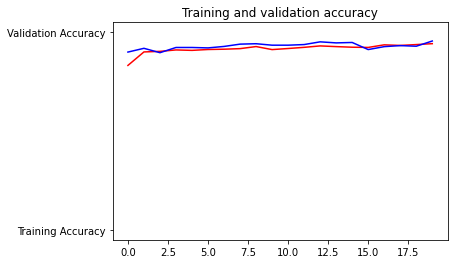

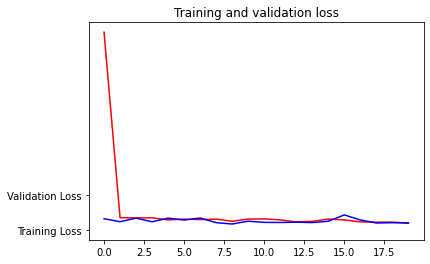

In [34]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [37]:
def predict_image_mobilenet(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 300, 300, 3])

  predict_array = model_mobilenet.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Anorganic', 'Toxic Waste', 'Organic']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model_mobilenet.predict(im_input))

  if predict_label == 0:
      predict_product = 'Anorganic'
  elif predict_label == 1:
      predict_product = 'Toxic Waste'
  else:
      predict_product = 'Organic'

  return predict_product, df

Saving download.jpg to download (7).jpg




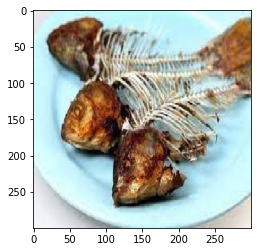


The image is detected as Organic


       Product  Probability
0    Anorganic     0.000049
1  Toxic Waste     0.071517
2      Organic     0.928435




In [40]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(300,300))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image_mobilenet(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')

##Convert to TF Lite Model 1##

In [41]:
export_dir = 'tmp/saved_model/'

tf.keras.models.save_model(model, export_dir)

INFO:tensorflow:Assets written to: tmp/saved_model/assets


In [42]:
optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) 

converter.optimizations = [optimization] 

tflite_model = converter.convert() 

In [43]:
import pathlib
tflite_model_file = pathlib.Path('./InceptionV3_Transfer_Learning_Updated_Dataset_300x300.tflite')
tflite_model_file.write_bytes(tflite_model)

62694112

##Convert to TF Lite Model 2##

In [44]:
export_dir = 'tmp/saved_model2/'

tf.keras.models.save_model(model_mobilenet, export_dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: tmp/saved_model2/assets


In [45]:
optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) 

converter.optimizations = [optimization] 

tflite_model = converter.convert() 

In [46]:
import pathlib
tflite_model_file = pathlib.Path('./MobileNet_Transfer_Learning_Updated_Dataset_300x300.tflite')
tflite_model_file.write_bytes(tflite_model)

133719232